In [4]:
import sqlite3
import pandas as pd

# 1) LOAD THE CSV AND PARSE DATES
df = pd.read_csv("TCS.csv")
df["Date"] = pd.to_datetime(
    df["Date"], format="%d-%B-%Y"
)  # e.g. "31-July-2018" → 2018-07-31
df = df.sort_values("Date", ascending=True).reset_index(
    drop=True
)  # Ensure ascending order


In [5]:
# 2) PUSH INTO SQLITE (so we can run SQL queries)
#    Convert Date into ISO format (YYYY-MM-DD) so that SQL can match on exact strings.
df_sql = df.copy()
df_sql["Date"] = df_sql["Date"].dt.strftime("%Y-%m-%d")

conn = sqlite3.connect(":memory:")
df_sql.to_sql("tcs", conn, index=False, if_exists="replace")



889

In [6]:
# 3) EXTRACT CLOSE ON 01-JAN-2015 AND 31-JUL-2018 VIA SQL
query_close_2015 = "SELECT [Close Price] FROM tcs WHERE Date = '2015-01-01';"
query_close_2018 = "SELECT [Close Price] FROM tcs WHERE Date = '2018-07-31';"

close_2015 = conn.execute(query_close_2015).fetchone()[0]
close_2018 = conn.execute(query_close_2018).fetchone()[0]


In [7]:
# 4) USE PANDAS TO COMPUTE “BUY”/“SELL” SIGNALS (BASED ON PRICE MOVEMENT)
df["Prev_Close"] = df["Close Price"].shift(1)


def classify_signal(row):
    if pd.isna(row["Prev_Close"]):
        return "Hold"
    if row["Close Price"] > row["Prev_Close"]:
        return "Buy"
    elif row["Close Price"] < row["Prev_Close"]:
        return "Sell"
    else:
        return "Hold"


df["Signal"] = df.apply(classify_signal, axis=1)



In [8]:
# 5) COUNT NUMBER OF “BUY” AND “SELL” SIGNALS
buy_count = df[df["Signal"] == "Buy"].shape[0]
sell_count = df[df["Signal"] == "Sell"].shape[0]


In [9]:

# 6) DETERMINE TREND ON 05-JUN-2018
target_date = pd.to_datetime("05-06-2018", format="%d-%m-%Y")
row_05062018 = df[df["Date"] == target_date]
if not row_05062018.empty:
    comparison = float(row_05062018["Close Price"].iloc[0]) - float(
        row_05062018["Prev_Close"].iloc[0]
    )
    trend_05062018 = "up" if comparison > 0 else "down"
else:
    trend_05062018 = "Date not found in dataset"


In [10]:
# 7) PERCENTAGE CHANGE FROM 01-JAN-2015 TO 31-JUL-2018
percent_change = ((close_2018 - close_2015) / close_2015) * 100


In [11]:
# 8) PACKAGE ALL RESULTS INTO A TABLE AND DISPLAY
results = {
    "Metric": [
        "Buy Signals Count",
        "Sell Signals Count",
        "Trend on 05-06-2018",
        "Close Price on 01-01-2015",
        "Close Price on 31-07-2018",
        "Percentage Change (2015→2018)",
    ],
    "Value": [
        buy_count,
        sell_count,
        trend_05062018,
        close_2015,
        close_2018,
        f"{percent_change:.2f}%",
    ],
}

results_df = pd.DataFrame(results)



In [12]:
# Display the results
print(results_df.to_string(index=False))
# Close the SQLite connection
conn.close()
# Save the results to a CSV file
results_df.to_csv("TCS_Analysis_Results.csv",index=False)
# Save the results to an Excel file
results_df.to_excel("TCS_Analysis_Results.xlsx",index=False)

                       Metric    Value
            Buy Signals Count      445
           Sell Signals Count      442
          Trend on 05-06-2018     down
    Close Price on 01-01-2015   2548.2
    Close Price on 31-07-2018  1941.25
Percentage Change (2015→2018)  -23.82%


Matplotlib is building the font cache; this may take a moment.


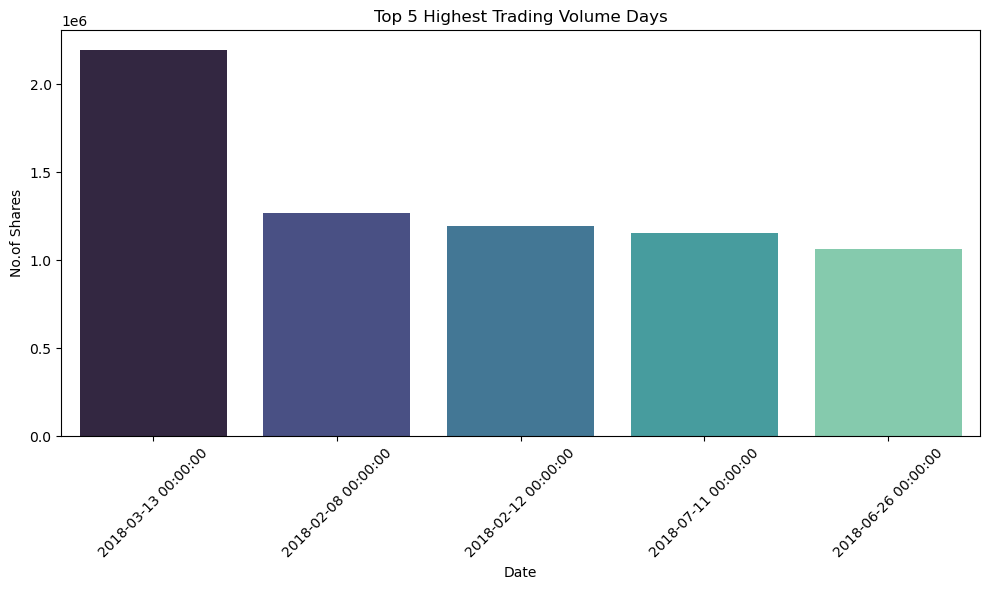

In [21]:
top_volume_days = df.nlargest(5, 'No.of Shares')

# Bar plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(x='Date', y='No.of Shares', data=top_volume_days, palette='mako')
plt.xticks(rotation=45)
plt.title('Top 5 Highest Trading Volume Days')
plt.tight_layout()
plt.show()


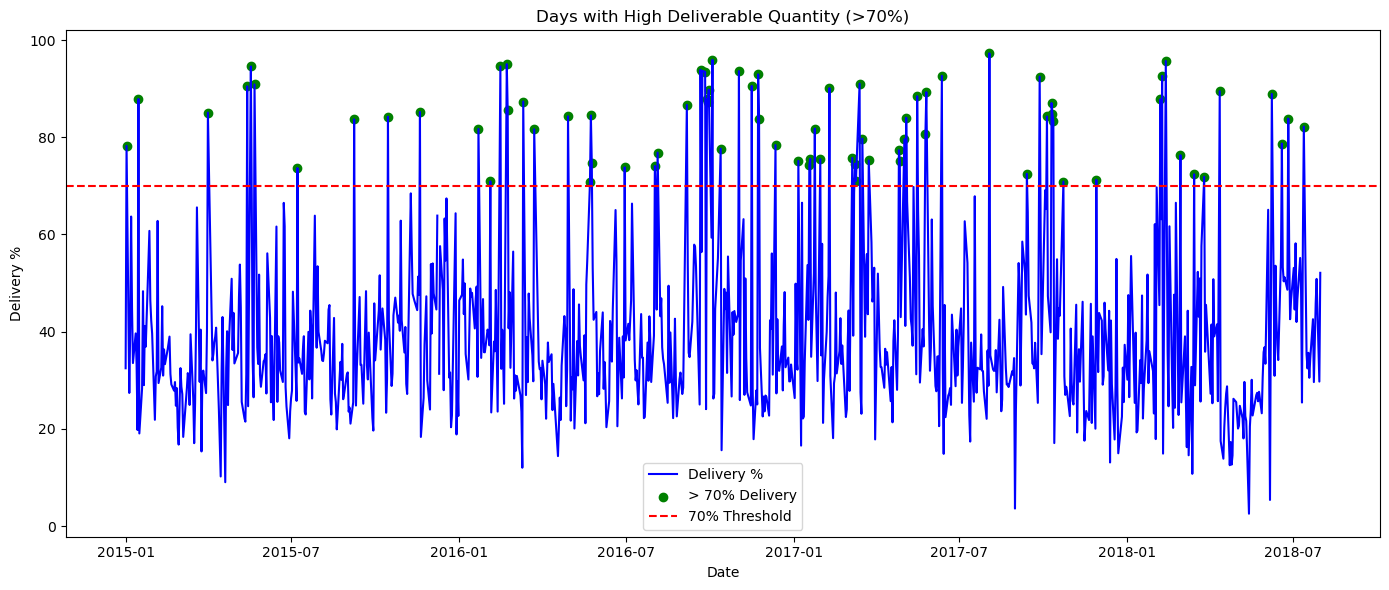

In [22]:
high_delivery_days = df[df['% Deli. Qty to Traded Qty'] > 70]

plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['% Deli. Qty to Traded Qty'], label='Delivery %', color='blue')
plt.scatter(high_delivery_days['Date'], high_delivery_days['% Deli. Qty to Traded Qty'], 
            color='green', label='> 70% Delivery')
plt.axhline(70, color='red', linestyle='--', label='70% Threshold')
plt.title('Days with High Deliverable Quantity (>70%)')
plt.xlabel('Date')
plt.ylabel('Delivery %')
plt.legend()
plt.tight_layout()
plt.show()


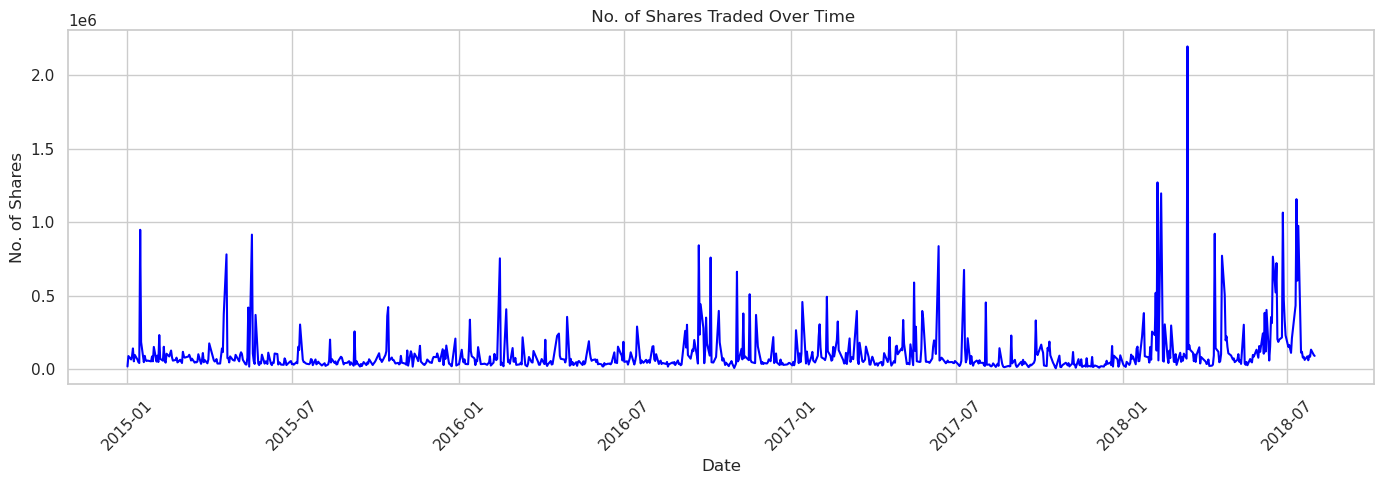

In [31]:
plt.figure(figsize=(14, 5))
sns.lineplot(data=df, x='Date', y='No.of Shares', color='blue')
plt.title(' No. of Shares Traded Over Time')
plt.xlabel('Date')
plt.ylabel('No. of Shares')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

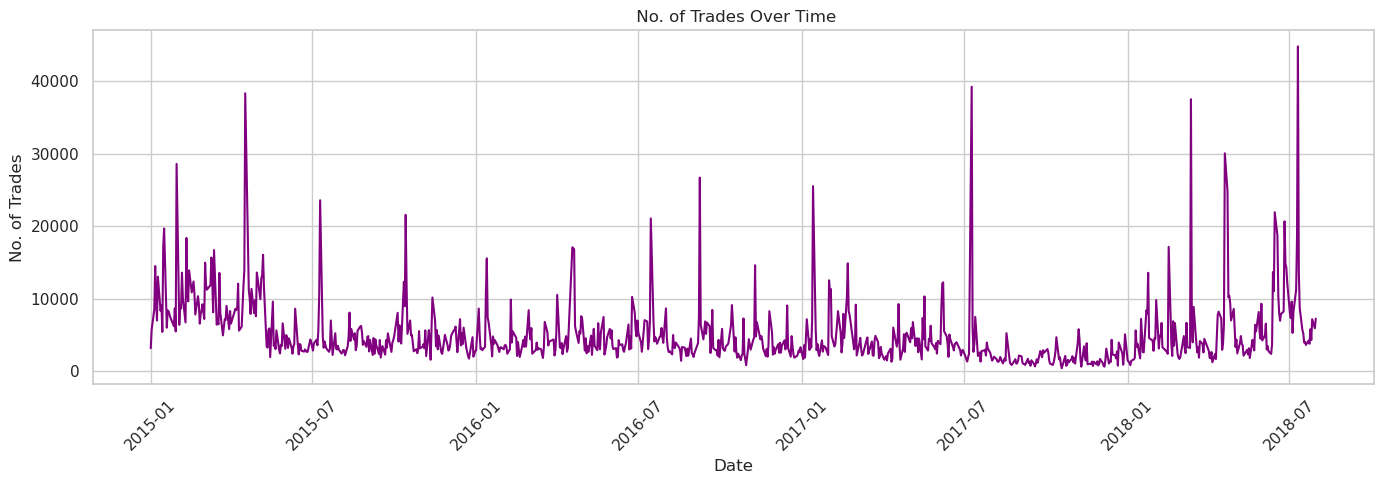

In [33]:
plt.figure(figsize=(14, 5))


sns.lineplot(data=df, x='Date', y='No. of Trades', color='purple')

plt.title(' No. of Trades Over Time')
plt.xlabel('Date')
plt.ylabel('No. of Trades')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

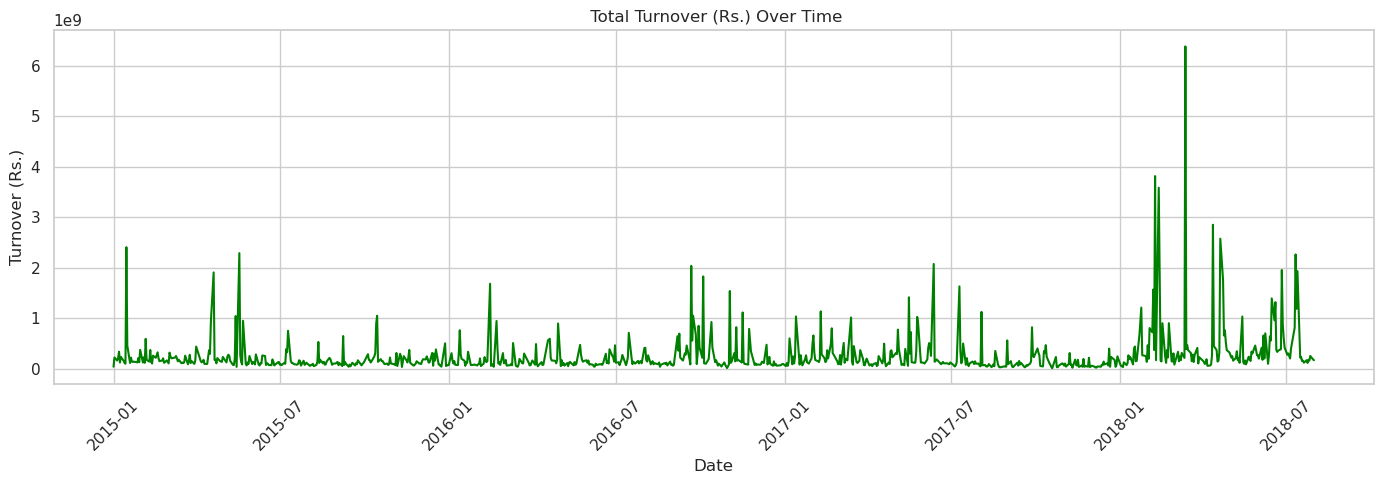

In [39]:
plt.figure(figsize=(14, 5))


sns.lineplot(data=df, x='Date', y='Total Turnover (Rs.)', color='green')  # Make sure this matches exactly
plt.title(' Total Turnover (Rs.) Over Time')
plt.xlabel('Date')
plt.ylabel('Turnover (Rs.)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

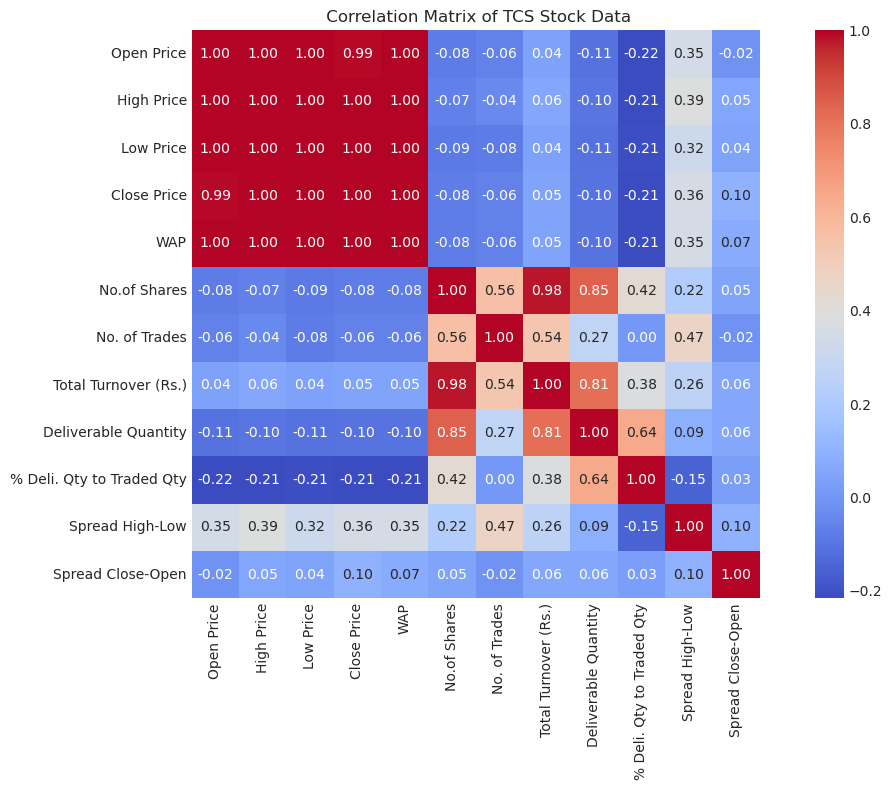

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("TCS.csv")

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%B-%Y')
df.sort_values('Date', inplace=True)

# Drop non-numeric columns (e.g., 'Date', 'Symbol' if present)
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# --- 1️⃣ Correlation Heatmap ---
plt.figure(figsize=(12, 8))
corr_matrix = df_numeric.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title(' Correlation Matrix of TCS Stock Data')
plt.tight_layout()
plt.show()



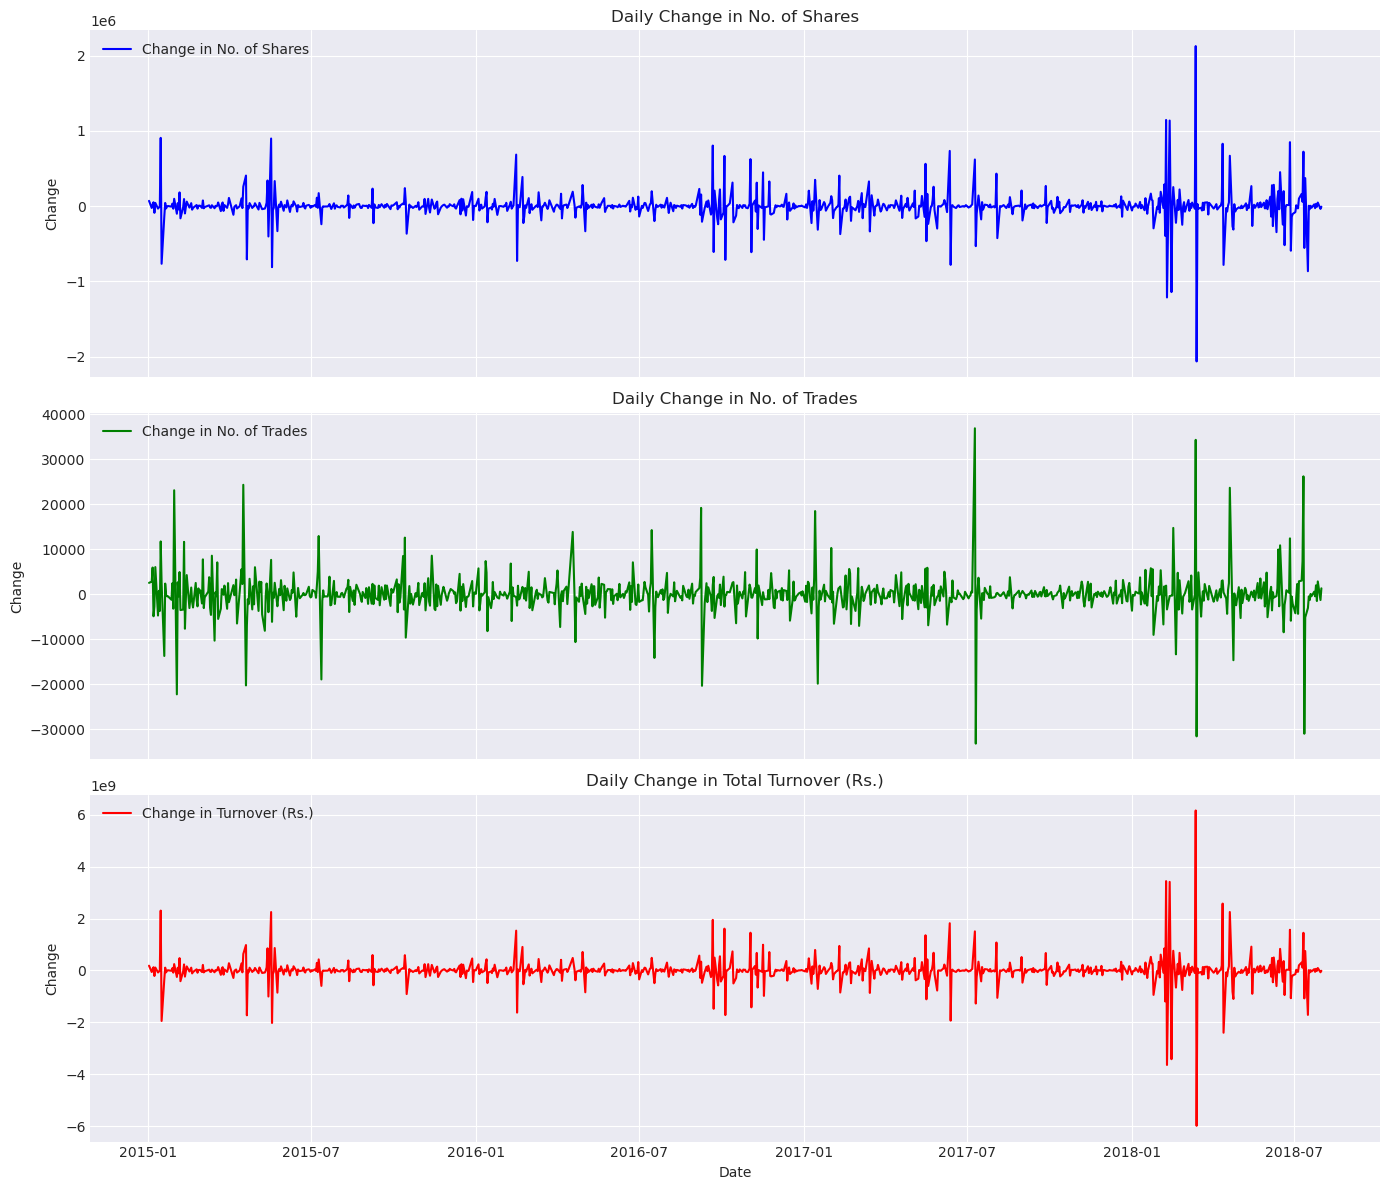

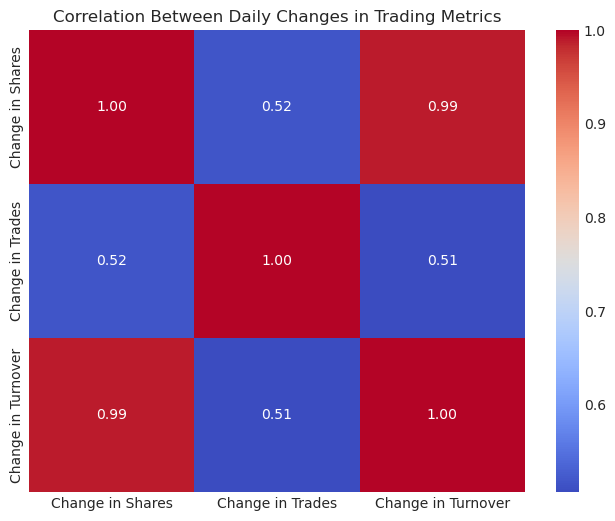

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv("TCS.csv")

# Convert 'Date' column to datetime and sort
df['Date'] = pd.to_datetime(df['Date'], format="%d-%B-%Y")
df = df.sort_values('Date')

# Compute daily changes
df['Change in Shares'] = df['No.of Shares'].diff()
df['Change in Trades'] = df['No. of Trades'].diff()
df['Change in Turnover'] = df['Total Turnover (Rs.)'].diff()

# Plot time series of changes
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

axes[0].plot(df['Date'], df['Change in Shares'], color='blue', label='Change in No. of Shares')
axes[1].plot(df['Date'], df['Change in Trades'], color='green', label='Change in No. of Trades')
axes[2].plot(df['Date'], df['Change in Turnover'], color='red', label='Change in Turnover (Rs.)')

axes[0].set_title('Daily Change in No. of Shares')
axes[1].set_title('Daily Change in No. of Trades')
axes[2].set_title('Daily Change in Total Turnover (Rs.)')
axes[2].set_xlabel('Date')

for ax in axes:
    ax.set_ylabel('Change')
    ax.legend()

plt.tight_layout()
plt.show()

# Correlation analysis
change_df = df[['Change in Shares', 'Change in Trades', 'Change in Turnover']].dropna()
corr_matrix = change_df.corr()

# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Daily Changes in Trading Metrics')
plt.show()




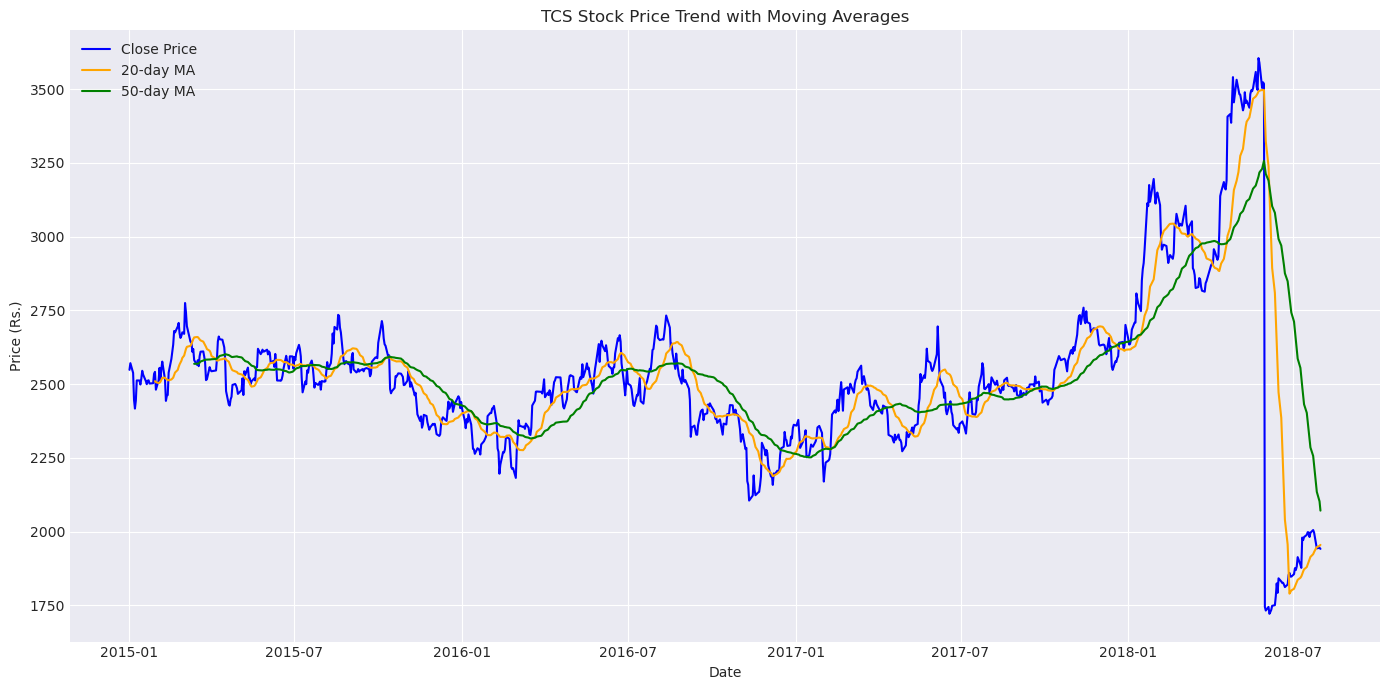

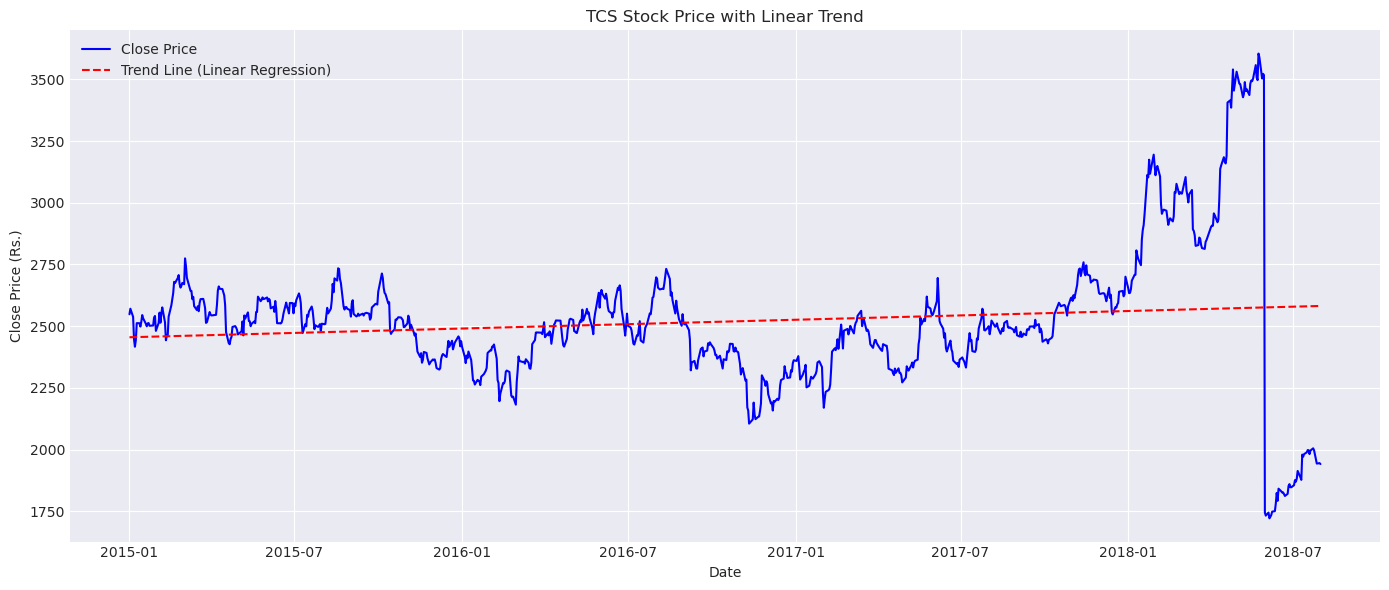

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np

# Load and prepare data
df = pd.read_csv("TCS.csv")
df['Date'] = pd.to_datetime(df['Date'], format="%d-%B-%Y")
df = df.sort_values('Date')

# Calculate Moving Averages
df['MA_20'] = df['Close Price'].rolling(window=20).mean()
df['MA_50'] = df['Close Price'].rolling(window=50).mean()

# Plot Close Price and Moving Averages
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close Price'], label='Close Price', color='blue')
plt.plot(df['Date'], df['MA_20'], label='20-day MA', color='orange')
plt.plot(df['Date'], df['MA_50'], label='50-day MA', color='green')
plt.title("TCS Stock Price Trend with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (Rs.)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Trend Line using Linear Regression
# Convert dates to ordinal for regression
df['Date_Ordinal'] = df['Date'].map(pd.Timestamp.toordinal)
X = df[['Date_Ordinal']]
y = df['Close Price']

# Remove missing values (if any)
X = X[y.notna()]
y = y.dropna()

# Fit linear regression
model = LinearRegression()
model.fit(X, y)
df['Trend_Line'] = model.predict(df[['Date_Ordinal']])

# Plot with trend line
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Close Price'], label='Close Price', color='blue')
plt.plot(df['Date'], df['Trend_Line'], label='Trend Line (Linear Regression)', color='red', linestyle='--')
plt.title("TCS Stock Price with Linear Trend")
plt.xlabel("Date")
plt.ylabel("Close Price (Rs.)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


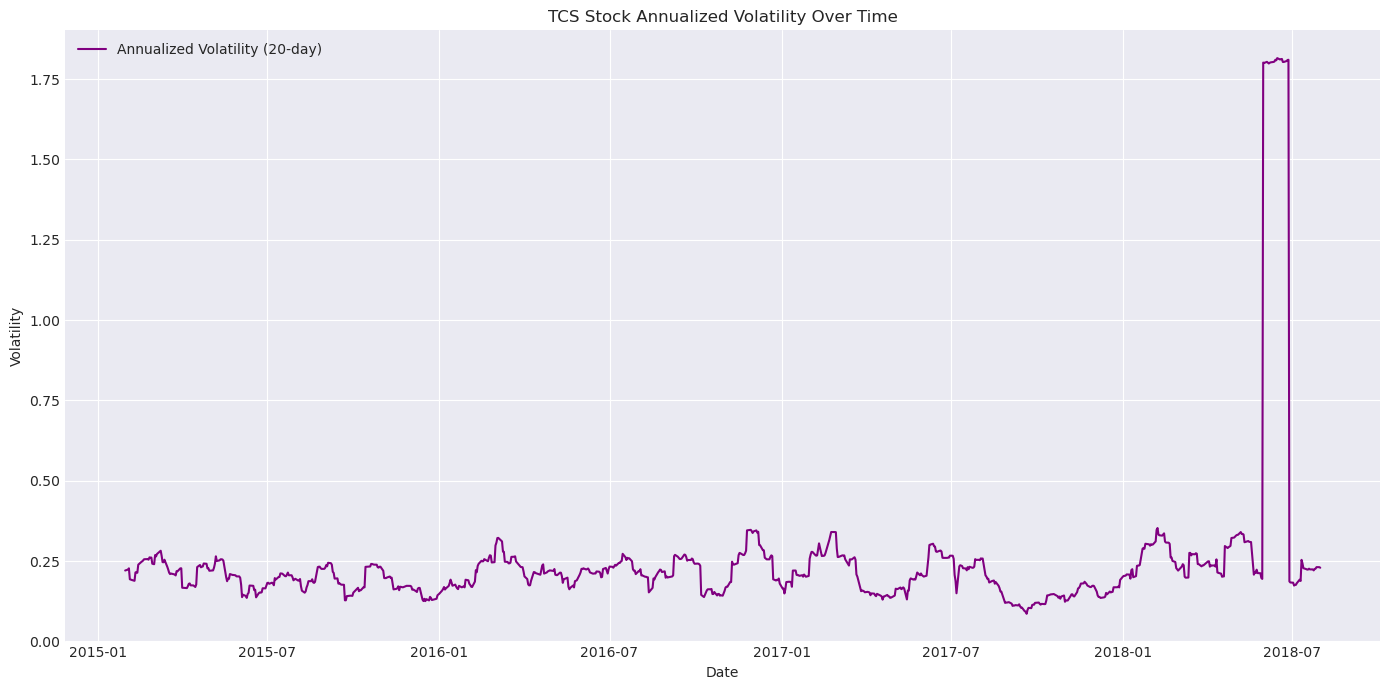

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("TCS.csv")
df['Date'] = pd.to_datetime(df['Date'], format="%d-%B-%Y")
df = df.sort_values('Date')

# Calculate daily returns
df['Daily Return'] = df['Close Price'].pct_change()

# Calculate 20-day rolling standard deviation (volatility)
df['Rolling Volatility (20d)'] = df['Daily Return'].rolling(window=20).std()

# Annualized Volatility = rolling std dev * sqrt(252)
df['Annualized Volatility'] = df['Rolling Volatility (20d)'] * np.sqrt(252)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Annualized Volatility'], label='Annualized Volatility (20-day)', color='purple')
plt.title('TCS Stock Annualized Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


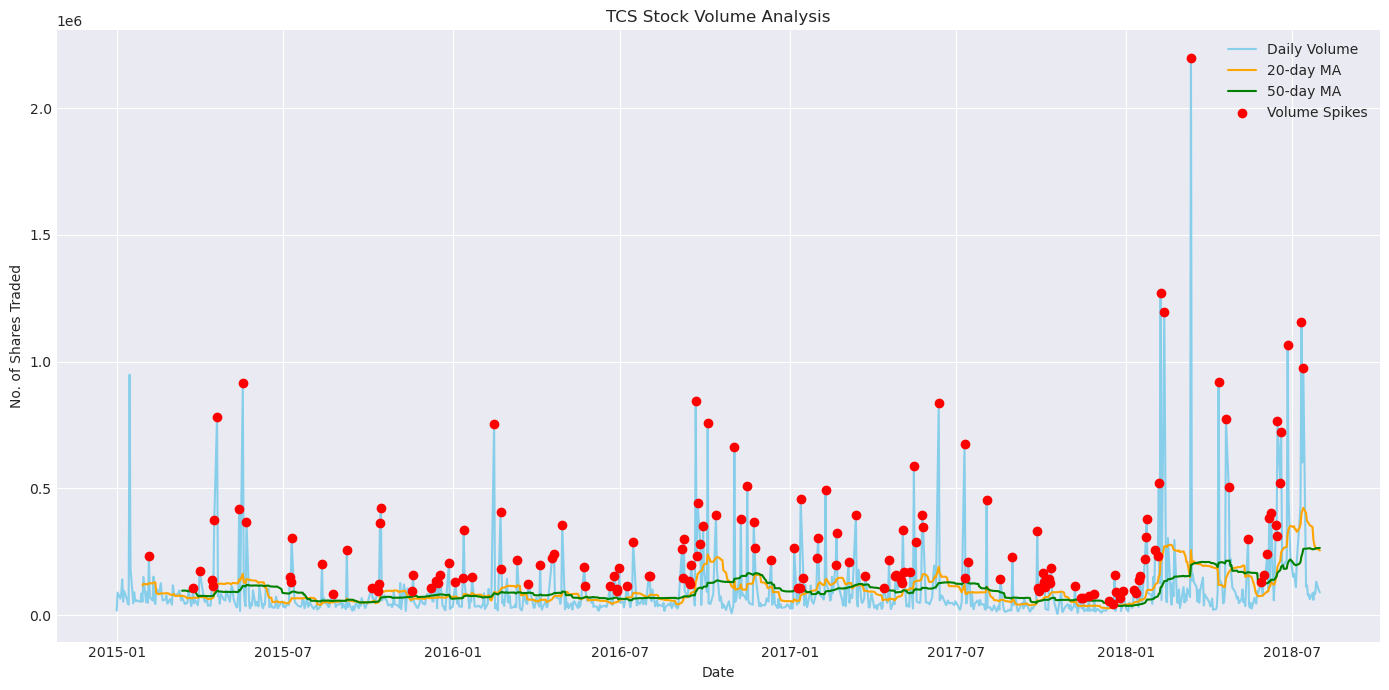

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and sort data
df = pd.read_csv("TCS.csv")
df['Date'] = pd.to_datetime(df['Date'], format="%d-%B-%Y")
df = df.sort_values('Date')

# Calculate Moving Averages of Volume
df['Volume_MA_20'] = df['No.of Shares'].rolling(window=20).mean()
df['Volume_MA_50'] = df['No.of Shares'].rolling(window=50).mean()

# Identify Volume Spikes (Volume > 1.5 * 20-day MA)
df['Volume_Spike'] = df['No.of Shares'] > 1.5 * df['Volume_MA_20']

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['No.of Shares'], label='Daily Volume', color='skyblue')
plt.plot(df['Date'], df['Volume_MA_20'], label='20-day MA', color='orange')
plt.plot(df['Date'], df['Volume_MA_50'], label='50-day MA', color='green')

# Mark volume spikes
plt.scatter(df.loc[df['Volume_Spike'], 'Date'], df.loc[df['Volume_Spike'], 'No.of Shares'],
            color='red', label='Volume Spikes', zorder=5)

plt.title('TCS Stock Volume Analysis')
plt.xlabel('Date')
plt.ylabel('No. of Shares Traded')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


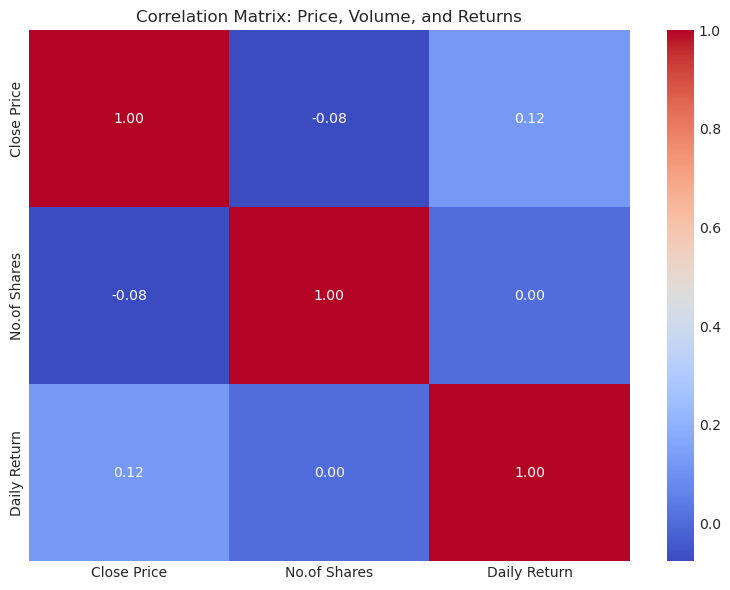

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and sort data
df = pd.read_csv("TCS.csv")
df['Date'] = pd.to_datetime(df['Date'], format="%d-%B-%Y")
df = df.sort_values('Date')

# Calculate daily returns
df['Daily Return'] = df['Close Price'].pct_change()

# Drop NA values (first return will be NaN)
df_clean = df[['Close Price', 'No.of Shares', 'Daily Return']].dropna()

# Correlation matrix
corr_matrix = df_clean.corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix: Price, Volume, and Returns')
plt.tight_layout()
plt.show()



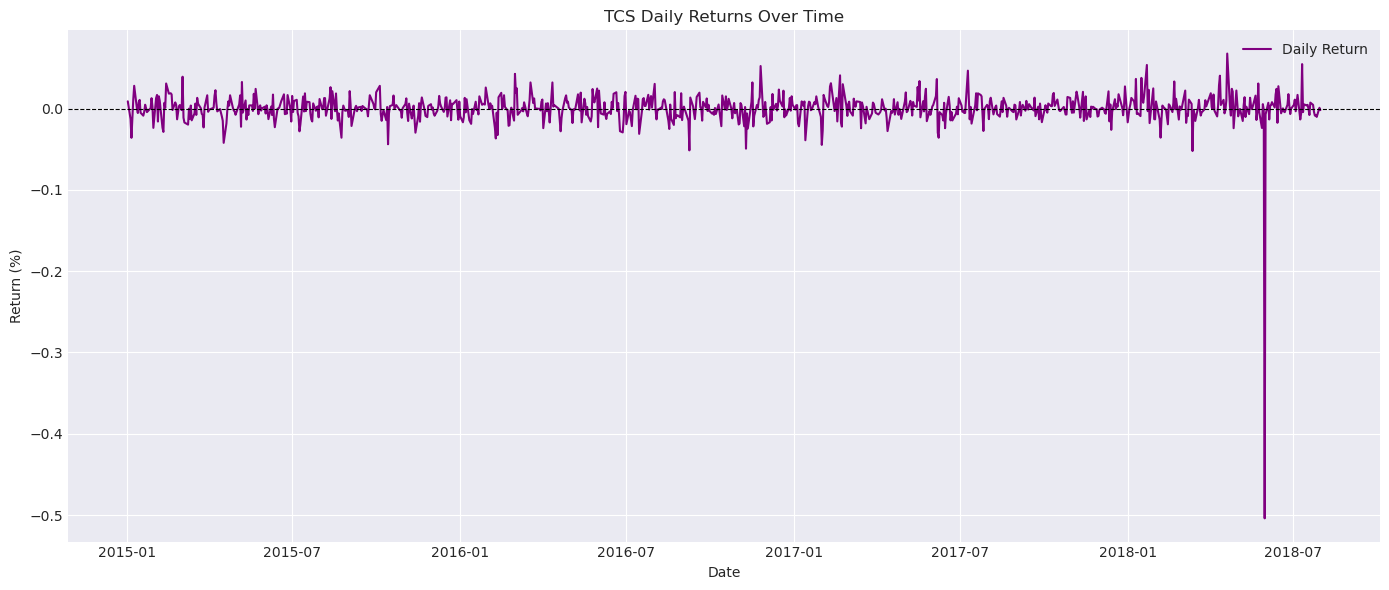

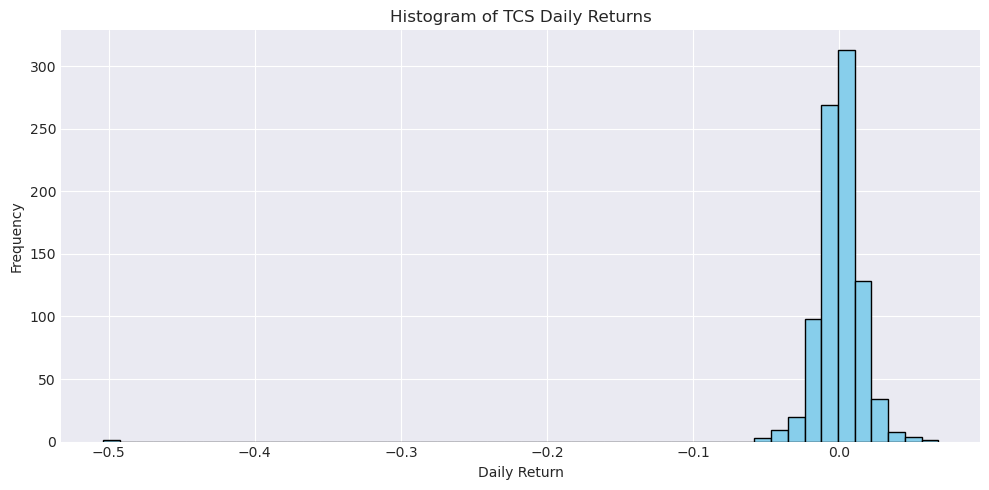

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and prepare data
df = pd.read_csv("TCS.csv")
df['Date'] = pd.to_datetime(df['Date'], format="%d-%B-%Y")
df = df.sort_values('Date')

# Calculate daily returns from Close Price
df['Daily Return'] = df['Close Price'].pct_change()

# Plot Daily Returns
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Daily Return'], color='purple', label='Daily Return')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title('TCS Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Return (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Histogram of Daily Returns
plt.figure(figsize=(10, 5))
plt.hist(df['Daily Return'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of TCS Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


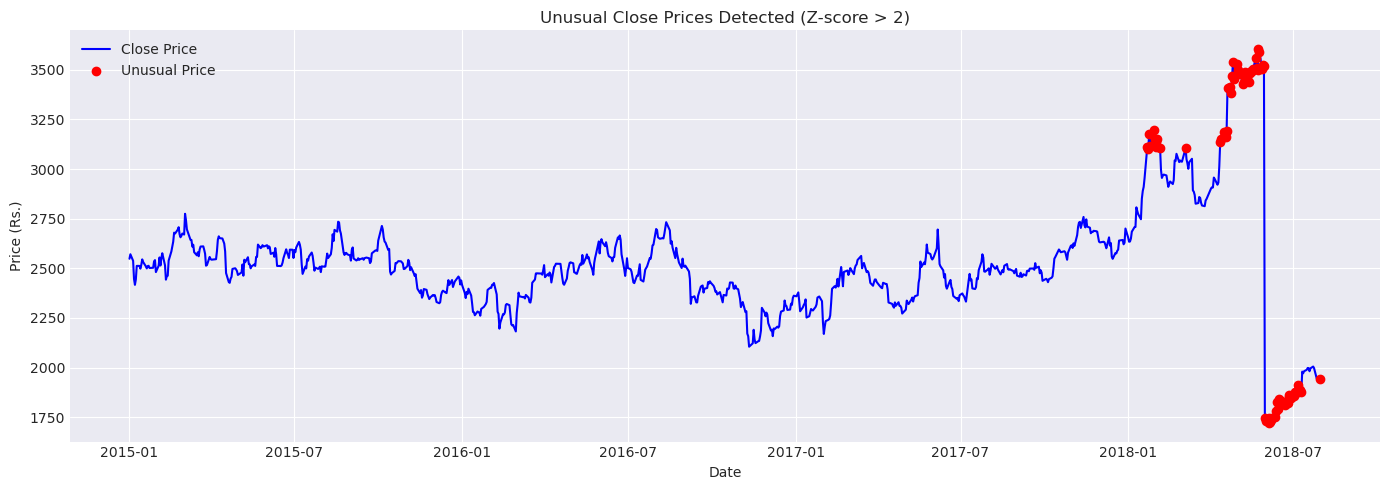

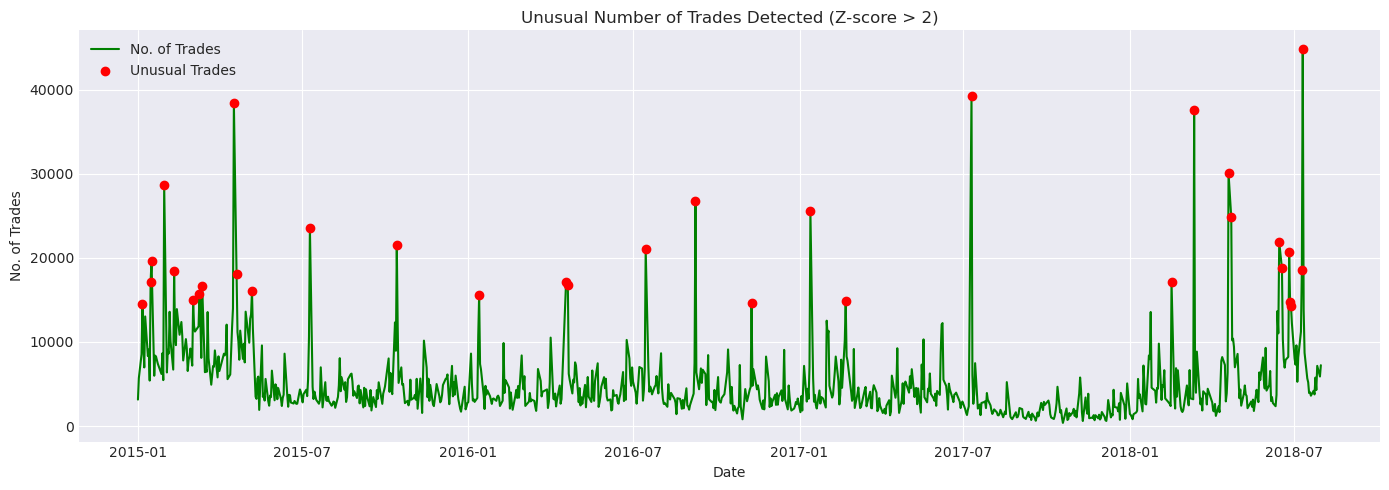

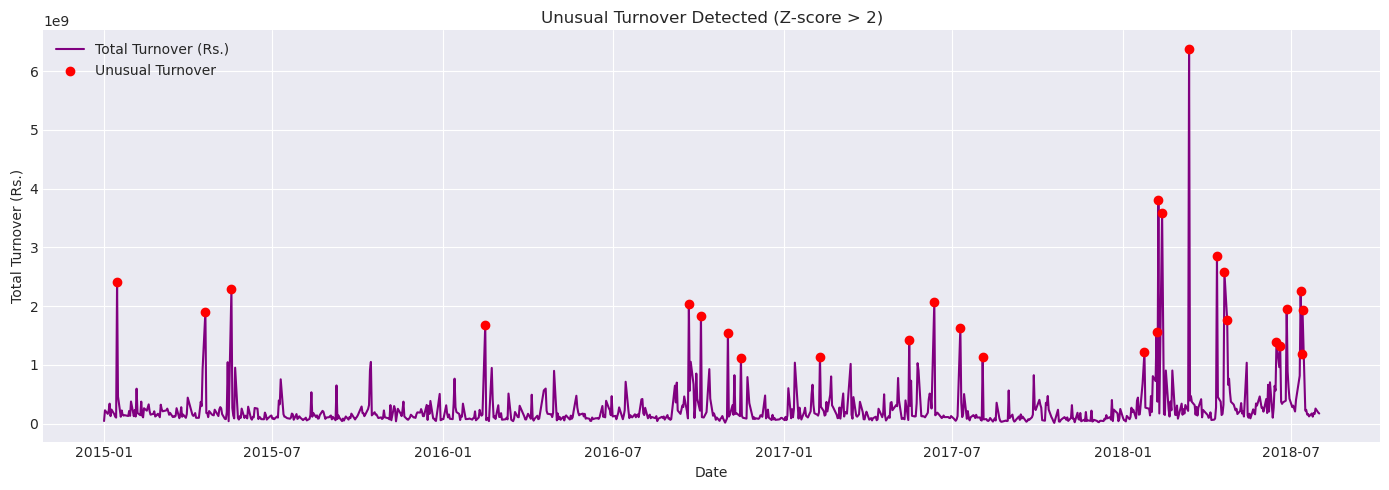

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load and sort data
df = pd.read_csv("TCS.csv")
df['Date'] = pd.to_datetime(df['Date'], format="%d-%B-%Y")
df = df.sort_values('Date')

# Calculate Z-scores
for col in ['Close Price', 'No. of Trades', 'Total Turnover (Rs.)']:
    df[f'{col} Z-score'] = (df[col] - df[col].mean()) / df[col].std()

# Identify outliers: Z-score beyond +/- 2
df['Price Outlier'] = df['Close Price Z-score'].abs() > 2
df['Trades Outlier'] = df['No. of Trades Z-score'].abs() > 2
df['Turnover Outlier'] = df['Total Turnover (Rs.) Z-score'].abs() > 2

# --- Visualization ---

# 1. Close Price with Outliers
plt.figure(figsize=(14, 5))
plt.plot(df['Date'], df['Close Price'], label='Close Price', color='blue')
plt.scatter(df.loc[df['Price Outlier'], 'Date'], df.loc[df['Price Outlier'], 'Close Price'],
            color='red', label='Unusual Price', zorder=5)
plt.title('Unusual Close Prices Detected (Z-score > 2)')
plt.xlabel('Date')
plt.ylabel('Price (Rs.)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

# 2. No. of Trades with Outliers
plt.figure(figsize=(14, 5))
plt.plot(df['Date'], df['No. of Trades'], label='No. of Trades', color='green')
plt.scatter(df.loc[df['Trades Outlier'], 'Date'], df.loc[df['Trades Outlier'], 'No. of Trades'],
            color='red', label='Unusual Trades', zorder=5)
plt.title('Unusual Number of Trades Detected (Z-score > 2)')
plt.xlabel('Date')
plt.ylabel('No. of Trades')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

# 3. Total Turnover with Outliers
plt.figure(figsize=(14, 5))
plt.plot(df['Date'], df['Total Turnover (Rs.)'], label='Total Turnover (Rs.)', color='purple')
plt.scatter(df.loc[df['Turnover Outlier'], 'Date'], df.loc[df['Turnover Outlier'], 'Total Turnover (Rs.)'],
            color='red', label='Unusual Turnover', zorder=5)
plt.title('Unusual Turnover Detected (Z-score > 2)')
plt.xlabel('Date')
plt.ylabel('Total Turnover (Rs.)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()
